[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fobos123deimos/fast-wave/blob/main/examples/speed_tests_numba_and_cython.ipynb)

In [ ]:
#@title Installation
!pip install fast_wave
!pip install mrmustard --no-deps
!pip install qutip


In [ ]:
#@title Imports and Definitions
import time
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from qutip.distributions import HarmonicOscillatorWaveFunction

from mrmustard.physics.fock import oscillator_eigenstate

import fast_wave.wavefunction_cython as wc
import fast_wave.wavefunction_numba as wn

HBAR = 2.0
h_bar_12 = np.sqrt(HBAR)
h_bar_14 = np.sqrt(h_bar_12)

%matplotlib inline

Functionality Test Passed: True


### Understanding Mr Mustard's strategy 🤔


---


[Mr Mustard](https://mrmustard.readthedocs.io/en/stable/index.html) is a Python library developed by the Canadian photonic quantum computing company [Xanadu](https://www.xanadu.ai/), focused on simulating continuous quantum computing based on Gaussian states using mathematical structures such as matrices and tensors. Additionally, the library can be used for wave function calculations, optimizations, quantum states, and time evolution processes.

This package contains a submodule named [fock](https://mrmustard.readthedocs.io/en/stable/_modules/mrmustard/physics/fock.html#oscillator_eigenstate) within the physics module for simulating quantum states in **Fock space** (a representation in quantum mechanics used to describe systems with a variable number of particles, such as a varying number of photons). In this submodule, there is a function named [oscillator_eigenstate](https://mrmustard.readthedocs.io/en/stable/code/api/mrmustard.physics.fock.oscillator_eigenstate.html), which is used to generate quantum states associated with vibrational modes, such as eigenfunctions of a quantum harmonic oscillator, within **Fock space**.

In essence, Mr Mustard's strategy is to use the [Renormalized Hermite Polynomial](https://arxiv.org/pdf/2209.06069) in conjunction with [Numba](https://numba.pydata.org/), a **JIT** compiler for translating Python code (mainly Numpy) into efficient machine code, for the computation of the wave function of a quantum harmonic oscillator. This implies an overhead on the first execution due to the compilation of the code that uses Numba.

$$H_{n+1}^{\; re}(x) = \displaystyle\frac{2}{\sqrt{n+1}}\bigg[xH_{n}^{\; re}(x) - H_{n-1}^{\; re}(x)\sqrt{n-1}\bigg]$$

$$H_{n}^{re}(x) = \displaystyle\frac{H_{n}(x)}{\sqrt{n!}}$$


Additionally, Mr Mustard uses **LRU (Least Recently Used)** cache management through the *@lru_cache* decorator from Python's [functools](https://docs.python.org/3/library/functools.html) library. This allows previous results to be stored, avoiding recalculation and thereby increasing the execution efficiency of the function. In this notebook, we provide an honest comparison of execution time between the fixed-precision modules (Numba and [Cython](https://cython.org/)) from the Fast Wave package, which uses another strategy, and the excellent strategy used by the **oscillator_eigenstate** function in the fock submodule of the Mr. Mustard package. It is important to note that the Cython modules do not have compilation overhead like those that use Numba, as they are already compiled files **.pyd** for Windows and **.so** for Linux.

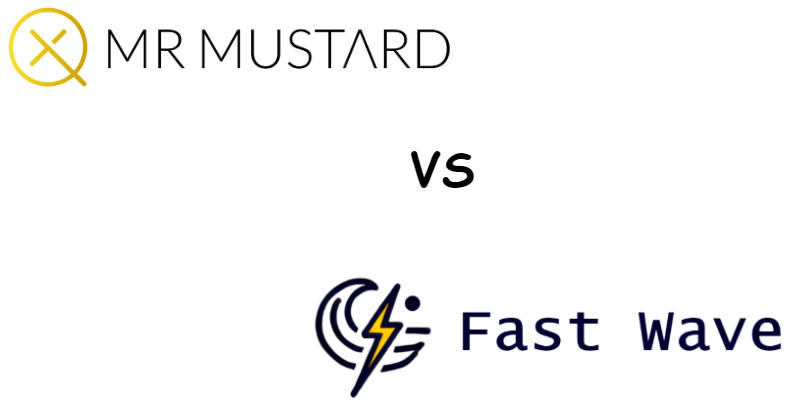

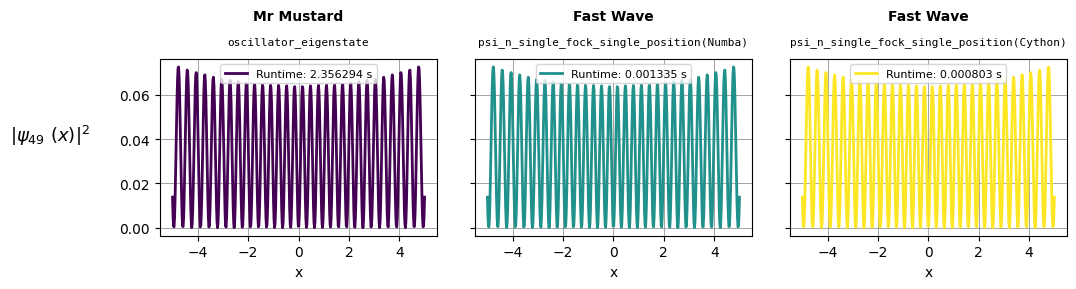

In [ ]:
#@title Comparing Mr Mustard's speed to Fast Wave (Single Fock & Single Position; real values)
n = 49 #@param
x_max = 5.0 #@param
x_min = -5.0 #@param
number_of_points = 500 #@param
use_normalized_hermite_coefficients_matrix_Numba = False #@param

x_values = np.linspace(x_min, x_max, number_of_points)

start_time = time.time()
y_Psi_n_x_Fast_Wave_Cython = [ abs(wc.psi_n_single_fock_single_position(n,x))**2 for x in x_values]
Fast_Wave_Cython_time = time.time() - start_time

start_time = time.time()
y_Psi_n_x_Fast_Wave_Numba = [ abs(wn.psi_n_single_fock_single_position(n,x,CS_matrix = use_normalized_hermite_coefficients_matrix_Numba))**2 for x in x_values]
Fast_Wave_Numba_time = time.time() - start_time

start_time = time.time()
y_Psi_n_x_Mr_Mustard = [abs((oscillator_eigenstate([x*h_bar_12],n+1)*h_bar_14)[-1][0])**2 for x in x_values]
Mr_Mustard_time = time.time() - start_time


plots = [y_Psi_n_x_Mr_Mustard, y_Psi_n_x_Fast_Wave_Numba, y_Psi_n_x_Fast_Wave_Cython]
titles = ["Mr Mustard", "Fast Wave", "Fast Wave"]
subtitles = ["oscillator_eigenstate", "psi_n_single_fock_single_position(Numba)",
             "psi_n_single_fock_single_position(Cython)"]
times = [Mr_Mustard_time, Fast_Wave_Numba_time, Fast_Wave_Cython_time]

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].set_ylabel('$|\psi_{%s} \ (x)|^{2}$'%n, fontsize = 13, rotation = 0,  labelpad = 50)
colors = plt.cm.viridis(np.linspace(0, 1, 3))

for i in range(len(plots)):
    axs[i].plot(x_values, plots[i], linewidth=2, color = colors[i], label=f"Runtime: {times[i]:.6f} s",)
    axs[i].grid(color='gray', linestyle='-', linewidth=0.5)
    axs[i].set_xlabel('x')

    axs[i].set_title(f"{titles[i]}", fontsize=10, fontweight='bold', pad=28)
    axs[i].text(0.5, 1.10, f"{subtitles[i]}", fontsize=8, fontfamily='monospace', ha='center', va='center', transform=axs[i].transAxes)
    axs[i].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()

$$$$
$$ \qquad \qquad \qquad \qquad \psi_{n}(X_{m}) = \bigg[\psi_{n}(x_{0}), \psi_{n}(x_{1}), ..., \psi_{n}(x_{m})\bigg] \implies \big|\psi_{n}(X_{m})\big|^{2} = \bigg[\ |\psi_{n}(x_{0})|^2, |\psi_{n}(x_{1})|^2, ..., |\psi_{n}(x_{m})|^2 \ \bigg] $$



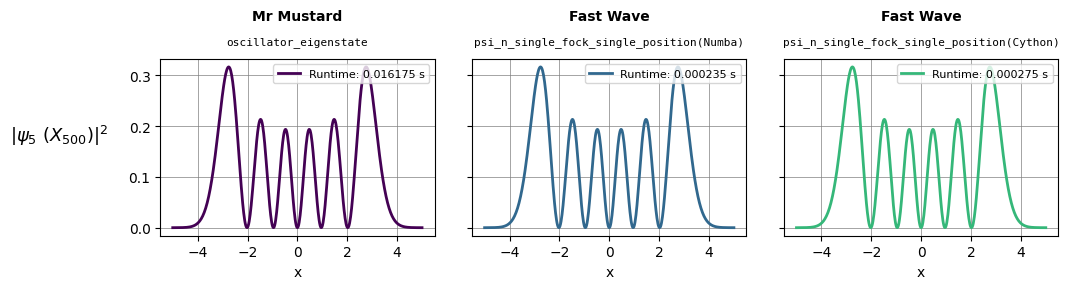

In [ ]:
#@title Comparing Mr Mustard's speed to Fast Wave (Single Fock & Multiple Position; real values)

n = 5 #@param
x_max = 5.0 #@param
x_min = -5.0 #@param
number_of_points = 500 #@param
use_normalized_hermite_coefficients_matrix_Numba = False #@param

x_values = np.linspace(x_min, x_max, number_of_points)

start_time = time.time()
y_Psi_n_x_Fast_Wave_Cython = (abs(wc.psi_n_single_fock_multiple_position(n,x_values))**2).tolist()
Fast_Wave_Cython_time = time.time() - start_time

start_time = time.time()
y_Psi_n_x_Fast_Wave_Numba = (abs(wn.psi_n_single_fock_multiple_position(n,x_values, CS_matrix = use_normalized_hermite_coefficients_matrix_Numba))**2).tolist()
Fast_Wave_Numba_time = time.time() - start_time

start_time = time.time()
y_Psi_n_x_Mr_Mustard = (abs((oscillator_eigenstate(x_values*h_bar_12,n+1)*h_bar_14)[-1])**2).tolist()
Mr_Mustard_time = time.time() - start_time


plots = [y_Psi_n_x_Mr_Mustard, y_Psi_n_x_Fast_Wave_Numba, y_Psi_n_x_Fast_Wave_Cython]
titles = ["Mr Mustard", "Fast Wave", "Fast Wave"]
subtitles = ["oscillator_eigenstate", "psi_n_single_fock_single_position(Numba)", "psi_n_single_fock_single_position(Cython)"]
times = [Mr_Mustard_time, Fast_Wave_Numba_time, Fast_Wave_Cython_time]

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].set_ylabel('$|\psi_{%s} \ (X_{%s})|^{2}$'% (n,number_of_points), fontsize = 13, rotation = 0,  labelpad = 50)
colors = plt.cm.viridis(np.linspace(0, 1, 4))

for i in range(len(plots)):
    axs[i].plot(x_values, plots[i], linewidth=2, color = colors[i], label=f"Runtime: {times[i]:.6f} s",)
    axs[i].grid(color='gray', linestyle='-', linewidth=0.5)
    axs[i].set_xlabel('x')

    axs[i].set_title(f"{titles[i]}", fontsize=10, fontweight='bold', pad=28)
    axs[i].text(0.5, 1.10, f"{subtitles[i]}", fontsize=8, fontfamily='monospace', ha='center', va='center', transform=axs[i].transAxes)
    axs[i].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()